In [1]:
import uproot 
import numpy as np
import coffea
from coffea.nanoaod import NanoEvents
from coffea.nanoaod.methods.leptons import *
from coffea import hist
import matplotlib.pyplot as plt

In [2]:
fname="/uscms/home/therwig/nobackup/public/forDominic/CRAB3_sos_28may2020_testHinoProd_nano.root"
events = NanoEvents.from_file(fname,methods={"ElectronBPark":Electron})

In [3]:
def makeroc(sig, bkg, binning, direction=1):
    '''Given a signal and background discriminant array, along with a binning,
    compute the ROC curve by integrating discriminant histograms along a direction:
        1: cut < value
        -1: cut >= value
    Returns a tuple of (signal efficiency, background efficiency)'''
    sighist, _ = np.histogram(sig, bins=binning)
    bkghist, _ = np.histogram(bkg, bins=binning)
    # numpy histogram will ignore values out of range of our binning (overflow)
    # so add the overflow values that would pass given our cut direction
    if direction == 1:
        sighist[0] += sum(sig < binning[0])
        bkghist[0] += sum(bkg < binning[0])
    elif direction == -1:
        sighist[-1] += sum(sig > binning[-1])
        bkghist[-1] += sum(bkg > binning[-1])
    else:
        raise ValueError("Invalid direction")
    sigpass = (np.cumsum(sighist[::direction]) / len(sig))[::direction]
    bkgpass = (np.cumsum(bkghist[::direction]) / len(bkg))[::direction]
    return (sigpass, bkgpass)

In [4]:
#cuts on MET and Jet
MET_mask = events.MET.pt >120
Jet_mask = events.Jet.pt.max() > 80
MET_Jet_mask = MET_mask & Jet_mask

soft_eles = events[MET_Jet_mask].ElectronBPark

GenPart_mask = ((events[MET_Jet_mask].GenPart.pdgId == 11) 
               #& (events[MET_Jet_mask].GenPart.parent.pdgId == 1000023) 
               & (events[MET_Jet_mask].GenPart.status == 1) 
               & (events[MET_Jet_mask].GenPart.hasFlags(["fromHardProcess", "isFirstCopy"])))
#delta_r criteria for matched and unmatched electrons
eles = soft_eles.cross(events[MET_Jet_mask].GenPart[GenPart_mask], nested=True)
matched_mask = (eles.i0.delta_r(eles.i1)).min() < 0.005
unmatched_mask = (eles.i0.delta_r(eles.i1)).min() >= 0.005
matched_eles = soft_eles[matched_mask]
unmatched_eles = soft_eles[unmatched_mask]

In [6]:
# x=0
# #& (events[MET_Jet_mask].GenPart.status == 1) & (events[MET_Jet_mask].GenPart.hasFlags(["fromHardProcess", "isFirstCopy"]))
# mask=(events[MET_Jet_mask].GenPart.parent.pdgId == 1000023) & (events[MET_Jet_mask].GenPart.pdgId == 11)
# for i in mask.flatten():
#     if i==True:
#         x=x+1
        
# print(x)

In [7]:
# for i in events[MET_Jet_mask].GenPart[events[MET_Jet_mask].GenPart.pdgId == 11].parent.pdgId.flatten():
#     if i!=None:
#         if (i>20 and i<30 and i==22):
#             print(i)


In [86]:
#apply cut to jagged array regardless of shape
#resulting array still needs to be flattened if needed
def cut(electrons):
    return electrons[
        (electrons.pt > 1) & (electrons.pt<5)
    ]

def cut1(electrons):
    return electrons[
        (electrons.pt > 1) & (electrons.pt<5)
        & (abs(electrons.eta) < 1.4)
        & (electrons.ip3d < 5)
        & (abs(electrons.dz) < 15)
        & (abs(electrons.dxy) < 0.1)
        & (electrons.trkRelIso < 15)#Why is this so significant
    ]
def cut2(electrons):
    return electrons[
        (electrons.pt > 1) & (electrons.pt<5)
        & (abs(electrons.eta) < 1.4)
        & (electrons.ip3d < 0.03)
        & (electrons.sip3d < 4)
        & (abs(electrons.dz) < 0.02)
         & (abs(electrons.dxy) < 0.02)
        &(electrons.ptBiased > 0)
        & (electrons.unBiased >0)
      & (electrons.trkRelIso < 15)#Why is this so significant?
    ]

In [87]:
roc_mva_cut= makeroc(
    sig=cut(matched_eles.flatten()).mvaId,
    bkg=cut(unmatched_eles.flatten()).mvaId,
    binning=np.linspace(-15, 25, 80),
    direction=-1,
)

roc_mva_cut1= makeroc(
    sig=cut1(matched_eles.flatten()).mvaId,
    bkg=cut1(unmatched_eles.flatten()).mvaId,
    binning=np.linspace(-15, 25, 80),
    direction=-1,
)

roc_mva_cut2= makeroc(
    sig=cut2(matched_eles.flatten()).mvaId,
    bkg=cut2(unmatched_eles.flatten()).mvaId,
    binning=np.linspace(-15, 25, 80),
    direction=-1,
)

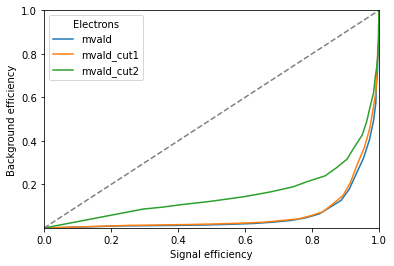

In [88]:
fig1, ax1 = plt.subplots()

ax1.plot(*roc_mva_cut, label=r"mvaId")
ax1.plot(*roc_mva_cut1, label=r"mvaId_cut1")
ax1.plot(*roc_mva_cut2, label=r"mvaId_cut2")
diag = np.linspace(0, 1, 100)
ax1.plot(diag, diag, color='grey', linestyle='--')
ax1.set_xlabel("Signal efficiency")
ax1.set_ylabel("Background efficiency")
ax1.set_xlim(0, 1)
ax1.set_ylim(1e-3, 1)
# ax1.set_yscale('log')
ax1.legend(title=r'Electrons')

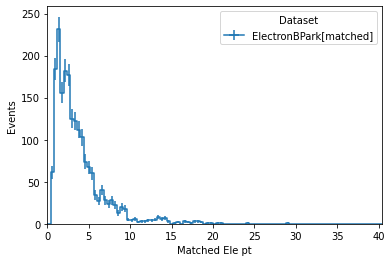

In [44]:
#matched electrons pt distribution
histo_matched_pt = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("pt", "Matched Ele pt", 100, 0, 40),
        )
histo_matched_pt.fill(dataset ="ElectronBPark[matched]", pt = matched_eles.pt.flatten())
#histo_matched_pt.fill(dataset ="ElectronBPark[unmatched]", pt = unmatched_eles.pt.flatten())
%matplotlib inline
hist.plot1d(histo_matched_pt, overflow = "over")

(-0.05, 0.05)

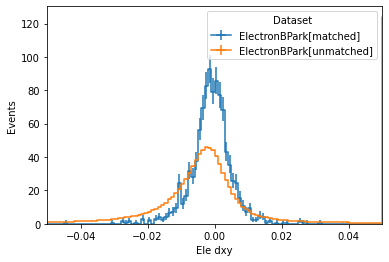

In [45]:
#guess cut: 0.02
histo_dxy = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("dxy", "Ele dxy", 100, -0.05, 0.05),
        )
histo_dxy.fill(dataset ="ElectronBPark[matched]", dxy = cut(matched_eles).dxy.flatten())
histo_dxy.fill(dataset ="ElectronBPark[unmatched]", dxy = cut(unmatched_eles).dxy.flatten())
%matplotlib inline
ax_dxy = hist.plot1d(histo_dxy, overflow = "over", density = True)
ax_dxy.set_xlim(right=0.05, left=-0.05)

(-0.02, 0.02)

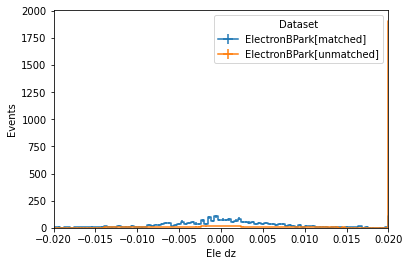

In [46]:
#guess cut: 0.02
histo_dz = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("dz", "Ele dz", 100, -.02, 0.02),
        )
histo_dz.fill(dataset ="ElectronBPark[matched]", dz = cut(matched_eles).dz.flatten())
histo_dz.fill(dataset ="ElectronBPark[unmatched]", dz = cut(unmatched_eles).dz.flatten())
%matplotlib inline
ax_dz = hist.plot1d(histo_dz, density = True, overflow = "over")
ax_dz.set_xlim(right=0.02, left=-.02)

(-3.0, 3.0)

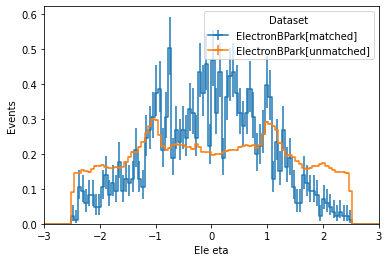

In [47]:
#guess cut: 3 (useless)
histo_eta = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("eta", "Ele eta", 100, -3, 3),
        )
histo_eta.fill(dataset ="ElectronBPark[matched]", eta = cut(matched_eles).eta.flatten())
histo_eta.fill(dataset ="ElectronBPark[unmatched]", eta = cut(unmatched_eles).eta.flatten())
%matplotlib inline
ax_eta = hist.plot1d(histo_eta, overflow = "over", density = True)
ax_eta.set_xlim(right=3, left=-3)

(-0.001, 0.03)

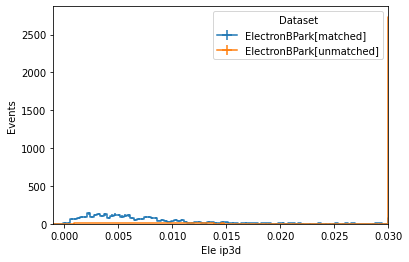

In [48]:
#guess cut: 0.03
histo_ip3d = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("ip3d", "Ele ip3d", 100, -0.001, 0.03),
        )
histo_ip3d.fill(dataset ="ElectronBPark[matched]", ip3d = cut(matched_eles).ip3d.flatten())
histo_ip3d.fill(dataset ="ElectronBPark[unmatched]", ip3d = cut(unmatched_eles).ip3d.flatten())
%matplotlib inline
ax_ip3d = hist.plot1d(histo_ip3d, density = True, overflow="over")
ax_ip3d.set_xlim(right=0.03, left=-0.001)

(0.001, 30.0)

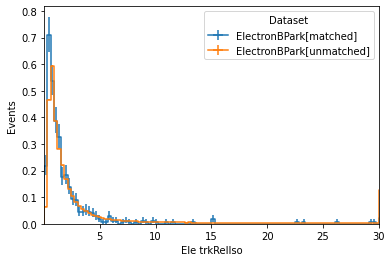

In [49]:
#guess cut: -----
histo_trkRelIso = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("trkRelIso", "Ele trkRelIso", 100, 0.001, 30),
        )
histo_trkRelIso.fill(dataset ="ElectronBPark[matched]", trkRelIso = cut(matched_eles).trkRelIso.flatten())
histo_trkRelIso.fill(dataset ="ElectronBPark[unmatched]", trkRelIso = cut(unmatched_eles).trkRelIso.flatten())
%matplotlib inline
ax_trkRelIso = hist.plot1d(histo_trkRelIso, density = True, overflow="over")
ax_trkRelIso.set_xlim(right=30, left=0.001)

(-25.0, 25.0)

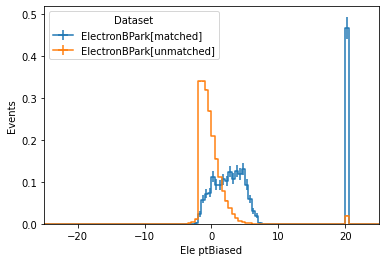

In [69]:
#guess cut:
histo_ptBiased = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("ptBiased", "Ele ptBiased", 100, -25, 25),
        )
histo_ptBiased.fill(dataset ="ElectronBPark[matched]", ptBiased = cut(matched_eles).ptBiased.flatten())
histo_ptBiased.fill(dataset ="ElectronBPark[unmatched]", ptBiased = cut(unmatched_eles).ptBiased.flatten())
%matplotlib inline
ax_ptBiased = hist.plot1d(histo_ptBiased, density = True, overflow="over")
ax_ptBiased.set_xlim(right=25, left=-25)

(-4.0, 4.0)

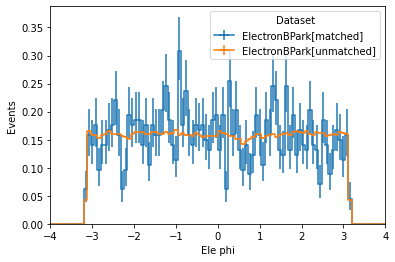

In [51]:
#guess cut:3.5 (useless)
histo_phi = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("phi", "Ele phi", 100, -4, 4),
        )
histo_phi.fill(dataset ="ElectronBPark[matched]", phi = cut(matched_eles).phi.flatten())
histo_phi.fill(dataset ="ElectronBPark[unmatched]", phi = cut(unmatched_eles).phi.flatten())
%matplotlib inline
ax_phi = hist.plot1d(histo_phi, density = True, overflow="over")
ax_phi.set_xlim(right=4, left=-4)

(-25.0, 25.0)

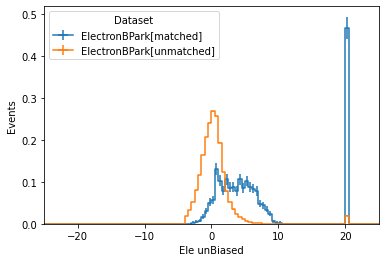

In [75]:
#guess cut:
histo_unBiased = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("unBiased", "Ele unBiased", 100, -25, 25),
        )
histo_unBiased.fill(dataset ="ElectronBPark[matched]", unBiased = cut(matched_eles).unBiased.flatten())
histo_unBiased.fill(dataset ="ElectronBPark[unmatched]", unBiased = cut(unmatched_eles).unBiased.flatten())
%matplotlib inline
ax_unBiased = hist.plot1d(histo_unBiased, density = True, overflow="over")
ax_unBiased.set_xlim(right=25, left=-25)

(-1.0, 1.5)

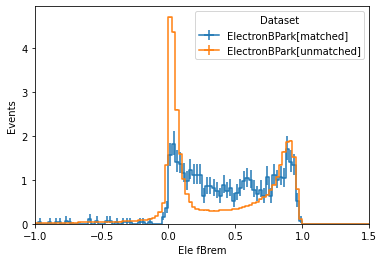

In [53]:
histo_fBrem = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("fBrem", "Ele fBrem", 100, -1, 1.5),
        )
histo_fBrem.fill(dataset ="ElectronBPark[matched]", fBrem = cut(matched_eles).fBrem.flatten())
histo_fBrem.fill(dataset ="ElectronBPark[unmatched]", fBrem = cut(unmatched_eles).fBrem.flatten())
%matplotlib inline
ax_fBrem = hist.plot1d(histo_fBrem, density = True, overflow="over")
ax_fBrem.set_xlim(right=1.5, left=-1)

(-10.0, 10.0)

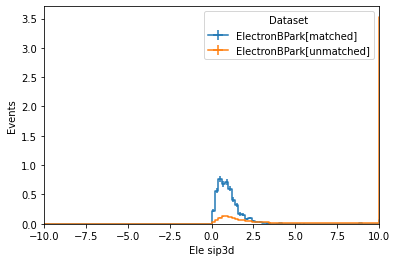

In [80]:
#guess cut: 4
histo_sip3d = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("sip3d", "Ele sip3d", 100, -10, 10),
        )
histo_sip3d.fill(dataset ="ElectronBPark[matched]", sip3d = cut(matched_eles).sip3d.flatten())
histo_sip3d.fill(dataset ="ElectronBPark[unmatched]", sip3d = cut(unmatched_eles).sip3d.flatten())
%matplotlib inline
ax_sip3d = hist.plot1d(histo_sip3d, density = True, overflow="over")
ax_sip3d.set_xlim(right=10, left=-10)

In [89]:
histo_all = hist.Hist(
            "All",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_pt", 150, 0, 5),
        )

histo_all.fill(variables="denominator", soft_ele = cut(matched_eles).pt.flatten())


/uscms/home/tamasan/miniconda3/envs/FireHydrant/lib/python3.8/site-packages/coffea/hist/plot.py:355: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


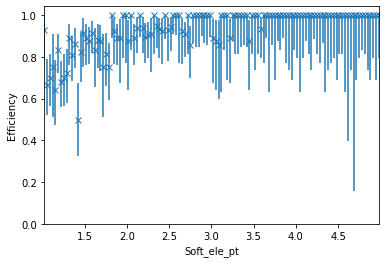

In [90]:
def cut_loose(electrons):
    return electrons[
        (electrons.pt > 1) & (electrons.pt<5)
        & (electrons.mvaId > 0)
    ]

histo_loose = hist.Hist(
            "Efficiency",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_pt", 150, 0, 5),
        )
histo_loose.fill(variables="looseMVA", soft_ele = cut_loose(matched_eles).pt.flatten())
%matplotlib inline
hist.plotratio(num=histo_loose.integrate("variables"), denom=histo_all.integrate("variables"), error_opts={"marker": "x"})

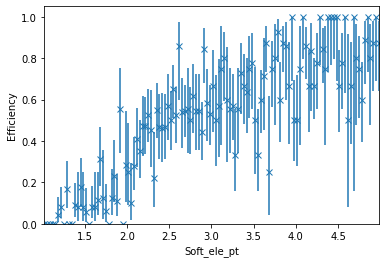

In [91]:
def cut_tight(electrons):
    return electrons[
        (electrons.pt > 1) & (electrons.pt<5)
        & (electrons.mvaId > 5)
    ]

histo_tight = hist.Hist(
            "Efficiency",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_pt", 150, 0, 5),
        )
histo_tight.fill(variables="looseMVA", soft_ele = cut_tight(matched_eles).pt.flatten())
%matplotlib inline
hist.plotratio(num=histo_tight.integrate("variables"), denom=histo_all.integrate("variables"), error_opts={"marker": "x"})

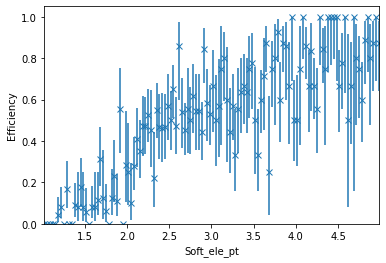

In [92]:
def cut_dxy(electrons):
    return electrons[
        (electrons.pt > 1) & (electrons.pt<5)
        & (abs(electrons.dxy) < 0.02)
        &(electrons.mvaId > 5)
        #& (electrons.trkRelIso < 0.3)
    ]

histo_dxy_eff = hist.Hist(
            "Efficiency",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_pt", 150, 0, 5),
        )
histo_dxy_eff.fill(variables="dxy", soft_ele = cut_dxy(matched_eles).pt.flatten())
%matplotlib inline
hist.plotratio(num=histo_dxy_eff.integrate("variables"), denom=histo_all.integrate("variables"), error_opts={"marker": "x"})

Text(0.5, 0, 'delta_r for matched BPark eles')

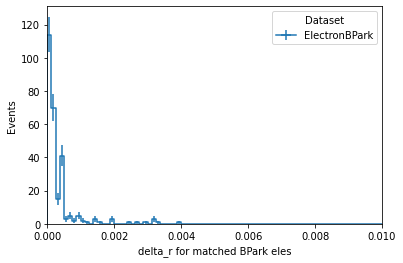

In [93]:
matched_ele_pairs = matched_eles.distincts(nested=True)

matched_delta_r = (matched_ele_pairs.i0.delta_r(matched_ele_pairs.i1)).min()
histo_delta_r = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("dr", "", 80, 0, 0.01),
        )

histo_delta_r.fill(dataset ="ElectronBPark", dr=matched_delta_r.flatten()[matched_delta_r.flatten()!=0])


%matplotlib inline
ax=hist.plot1d(histo_delta_r, overflow="over")
ax.set_xlim(right=0.01, left=0)
ax.set_xlabel("delta_r for matched BPark eles")

In [94]:
# histo_dr_all = hist.Hist(
#             "All",
#             hist.Cat("variables", "Variables"),
#             hist.Bin("soft_ele", "Soft_ele_dr", 150, 0, 10),
#         )
# eles_dr_all = cut(matched_eles).cross(events[MET_Jet_mask].GenPart[events[MET_Jet_mask].GenPart.pdgId == 11], nested=True)
# histo_dr_all.fill(variables="denominator", soft_ele = eles_dr_all.i0.delta_r(eles_dr_all.i1).min().flatten())

# histo_dr_eff = hist.Hist(
#             "Efficiency",
#             hist.Cat("variables", "Variables"),
#             hist.Bin("soft_ele", "Soft_ele_dr", 150, 0, 10),
#         )
# eles_dr_tight = cut_tight(matched_eles).cross(events[MET_Jet_mask].GenPart[events[MET_Jet_mask].GenPart.pdgId == 11], nested=True)
# histo_dr_eff.fill(variables="numerator", soft_ele = eles_dr_tight.i0.delta_r(eles_dr_tight.i1).min().flatten())
# %matplotlib inline
# ax_ele_dr=hist.plotratio(num=histo_dr_eff.integrate("variables"), denom=histo_dr_all.integrate("variables"), error_opts={"marker": "x"})


In [105]:
histo_dr_all = hist.Hist(
            "All",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_dr", 150, 0, 0.01),
        )
histo_dr_all.fill(variables="denominator", soft_ele = matched_delta_r.flatten()[matched_delta_r.flatten()!=0])

matched_ele_pairs_cut= cut_tight(matched_eles).distincts(nested=True)
matched_delta_r_cut= (matched_ele_pairs_cut.i0.delta_r(matched_ele_pairs_cut.i1))
histo_dr_eff = hist.Hist(
            "Efficiency",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_dr", 150, 0, 0.01),
        )
histo_dr_eff.fill(variables="numerator", soft_ele = matched_delta_r_cut.flatten()[matched_delta_r_cut.flatten()!=0])
%matplotlib inline
ax_ele_dr=hist.plotratio(num=histo_dr_eff.integrate("variables"), denom=histo_dr_all.integrate("variables"), error_opts={"marker": "x"})

TypeError: Request bin indices with a identifier or 1-D array only

In [104]:
matched_delta_r_cut.flatten()[matched_delta_r_cut.flatten()!=0]
matched_delta_r.flatten()[matched_delta_r.flatten()!=0]

array([2.4414062e-04, 3.4526698e-04, 2.4414062e-04, 1.2207031e-04,
       4.8828125e-04, 9.1552734e-05, 3.1738281e-03, 1.8310547e-04,
       1.2207031e-04, 4.8828125e-04, 6.8239380e-05, 1.5258789e-05,
       2.4414062e-04, 1.2207031e-04, 2.6855469e-03, 3.6621094e-04,
       4.8828125e-04, 1.2207031e-04, 1.2207031e-04, 2.4414062e-04,
       1.2207031e-04, 2.4414062e-04, 4.8828125e-04, 5.0330878e-04,
       2.4604058e-04, 1.5258789e-05, 2.4414062e-04, 2.4414062e-04,
       1.2207031e-04, 1.9540784e-03, 1.9531250e-03, 1.2207031e-04,
       1.2207031e-04, 1.5258789e-05, 2.1579186e-05, 2.4414062e-04,
       2.4414062e-04, 2.4414062e-04, 6.1035156e-05, 6.5736874e-04,
       1.0986328e-03, 3.0517578e-05, 6.1035156e-05, 2.4444561e-03,
       1.2207031e-04, 1.2207031e-04, 4.8828125e-04, 4.8828125e-04,
       1.9301011e-04, 2.4414062e-04, 9.7656250e-04, 1.2207031e-04,
       1.5258789e-04, 1.5258789e-04, 1.2207031e-04, 9.1552734e-05,
       6.1035156e-05, 1.2207031e-04, 1.4038086e-03, 6.1035156e

In [63]:
# f = (eles.i0.delta_r(eles.i1)).min()
# histo_test = hist.Hist(
#             "Events",
#             hist.Cat("dataset", "Dataset"),
#             hist.Bin("dr", "", 100, -.00001, 0.005),
#         )

# histo_test.fill(dataset ="Reco and Gen", dr=f.flatten())


# %matplotlib inline
# ax=hist.plot1d(histo_test)
# ax.set_xlim(right=0.005, left=-.00001)
# ax.set_xlabel("delta_r reco_gen.min")

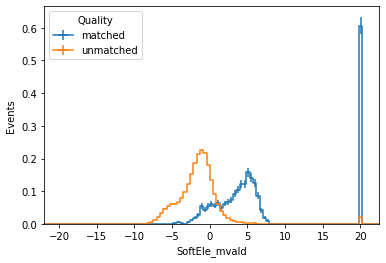

In [64]:
histo_mvaId = hist.Hist(
            "Events ",
            hist.Cat("quality", "Quality"),
            hist.Bin("soft_unmatched_ele", "SoftEle_mvaId", 100, -22, 22),
        )

histo_mvaId.fill(quality ="matched", soft_unmatched_ele=matched_eles.mvaId.flatten())
histo_mvaId.fill(quality ="unmatched", soft_unmatched_ele=unmatched_eles.mvaId.flatten())


%matplotlib inline
hist.plot1d(histo_mvaId, overflow = "over", density = True)

In [65]:
events.Electron.columns

['deltaEtaSC',
 'dr03EcalRecHitSumEt',
 'dr03HcalDepth1TowerSumEt',
 'dr03TkSumPt',
 'dr03TkSumPtHEEP',
 'dxy',
 'dxyErr',
 'dz',
 'dzErr',
 'eCorr',
 'eInvMinusPInv',
 'energyErr',
 'eta',
 'hoe',
 'ip3d',
 'jetPtRelv2',
 'jetRelIso',
 'mass',
 'miniPFRelIso_all',
 'miniPFRelIso_chg',
 'mvaFall17V1Iso',
 'mvaFall17V1noIso',
 'mvaFall17V2Iso',
 'mvaFall17V2noIso',
 'pfRelIso03_all',
 'pfRelIso03_chg',
 'phi',
 'pt',
 'r9',
 'sieie',
 'sip3d',
 'mvaTTH',
 'charge',
 'cutBased',
 'cutBased_Fall17_V1',
 'pdgId',
 'tightCharge',
 'vidNestedWPBitmap',
 'vidNestedWPBitmapHEEP',
 'convVeto',
 'cutBased_HEEP',
 'isPFcand',
 'lostHits',
 'mvaFall17V1Iso_WP80',
 'mvaFall17V1Iso_WP90',
 'mvaFall17V1Iso_WPL',
 'mvaFall17V1noIso_WP80',
 'mvaFall17V1noIso_WP90',
 'mvaFall17V1noIso_WPL',
 'mvaFall17V2Iso_WP80',
 'mvaFall17V2Iso_WP90',
 'mvaFall17V2Iso_WPL',
 'mvaFall17V2noIso_WP80',
 'mvaFall17V2noIso_WP90',
 'mvaFall17V2noIso_WPL',
 'seedGain',
 'genPartFlav',
 'cleanmask',
 'matched_jet',
 'matched

In [66]:
events.GenPart.hasFlags(["fromHardProcess", "isFirstCopy"])

<JaggedArray [[False False True ... False False False] [False False True ... True True True] [False False True ... True True True] ... [False False True ... True True False] [False False True ... False False False] [False False True ... False False False]] at 0x7f9cfc172130>

In [41]:
events[MET_Jet_mask].GenPart.status == 1

<JaggedArray [[False False False ... False False False] [False False False ... False True True] [False False False ... True True True] ... [False False False ... True True True] [False False False ... True True True] [False False False ... True True True]] at 0x7f5dea263640>